In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [1]:
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.backend import clear_session
from tensorflow.compat.v1.keras.backend import get_session

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [14]:
from numba import cuda
cuda.select_device(0)
cuda.close()

CudaAPIError: [2] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_OUT_OF_MEMORY

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from keras.optimizers import Adam

image_size = (512, 512) #(512,512) (720, 1280)
bs = 1

better_model = False
load_pretrained_weights = False

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

backbone = 'xception' #mobilenetv2, xception

NET = 'deeplab_' + backbone
PATH = '../kitti360_dataset.csv'

n_classes = 19

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', bs)


SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(bs)

Version 2.x.x
Num workers: 8
Backbone: xception
Path to dataset: ../kitti360_dataset.csv
N classes: 19
Image size: (512, 512)
Batch size: 1


## DeepLab V3+ And a SubPixel Upsampling Layer (better model) or Original

In [2]:
if better_model:
    model = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=load_pretrained_weights, 
                                      multi_gpu=False, backbone=backbone)
else:
    model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=load_pretrained_weights, 
                                      multi_gpu=False, backbone=backbone, infer=True)
    
#model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
#              loss = losses, metrics = metrics)
print('Weights path:', SegClass.modelpath)

nice
Cityscapes!
Weights path: weights/xception_original.h5


In [3]:
model.summary()

Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
_________________________________________________________________________________________

## Validate Model

In [4]:
import pandas as pd
from PIL import Image

dataset = pd.read_csv('../../kitti360_dataset.csv')
dataset = dataset[dataset['subset'] == 'test']
images = dataset.x.tolist()
labels = dataset.y.tolist()

In [9]:
dataset[dataset['scene'] == 2].shape

(10654, 4)

In [29]:
print(images[5])
print(labels[5])

/mnt/7BCDA59C6DEFFE3C/KITTI-360/data_2d_raw/2013_05_28_drive_0005_sync/image_00/data_rect/0000000041.png
/mnt/7BCDA59C6DEFFE3C/KITTI-360/data_2d_semantics/2013_05_28_drive_0005_sync/0000000041.png


(376, 1408)


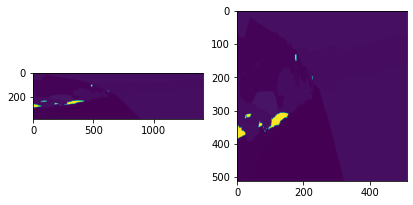

In [10]:
lab = cv2.imread(labels[5], 0)
print(lab.shape)
plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(lab)
lab = cv2.resize(lab, (512,512), interpolation = cv2.INTER_NEAREST)
plt.subplot(142)
plt.imshow(lab)

In [31]:
np.unique(lab)

array([  0,   1,   2,   4,   5,   7,   8,   9,  10,  13, 255], dtype=uint8)

In [10]:
t = lab.flatten()
#t = np.expand_dims(t, -1)
t.shape

(262144,)

In [17]:
import cv2

image = cv2.imread(images[140], 1)
image = cv2.resize(image, (512,512))

preds_proc = np.argmax(model.predict(np.expand_dims(image, 0)), -1)[0].reshape(image_size)
preds_proc = preds_proc.astype('uint8')

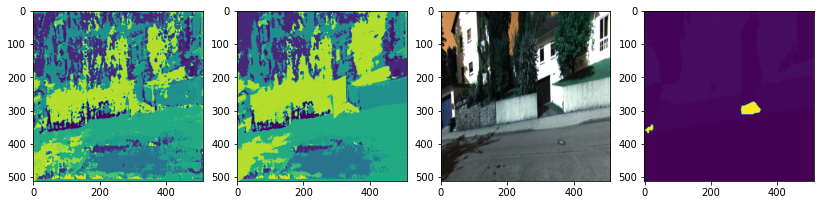

In [6]:
i = np.random.randint(0, len(test_generator))
x,y = test_generator.__getitem__(i)
preds1 = np.argmax(model.predict(x), -1)[0].reshape(image_size)
plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(preds1)
MAP = do_crf(x[0], preds1, zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP)
plt.subplot(143)
plt.imshow(x[0].astype('uint8'))
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))

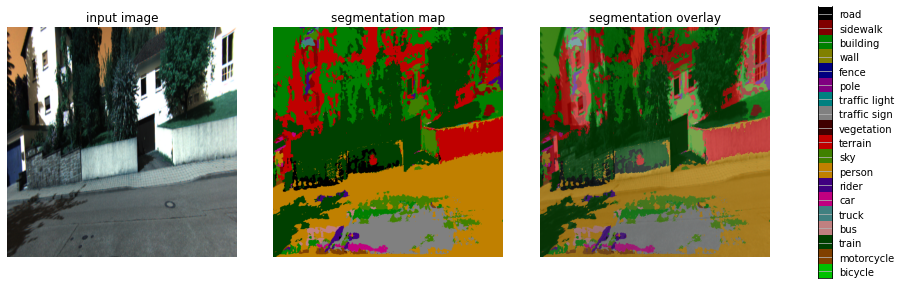

In [9]:
vis_segmentation(x[0].astype('uint8'),MAP)

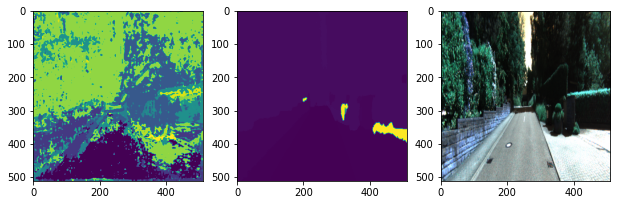

In [18]:
lab = cv2.imread(labels[140], 0)
lab = cv2.resize(lab, (512,512))

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(preds_proc)
plt.subplot(142)
plt.imshow(lab)
plt.subplot(143)
plt.imshow(image)

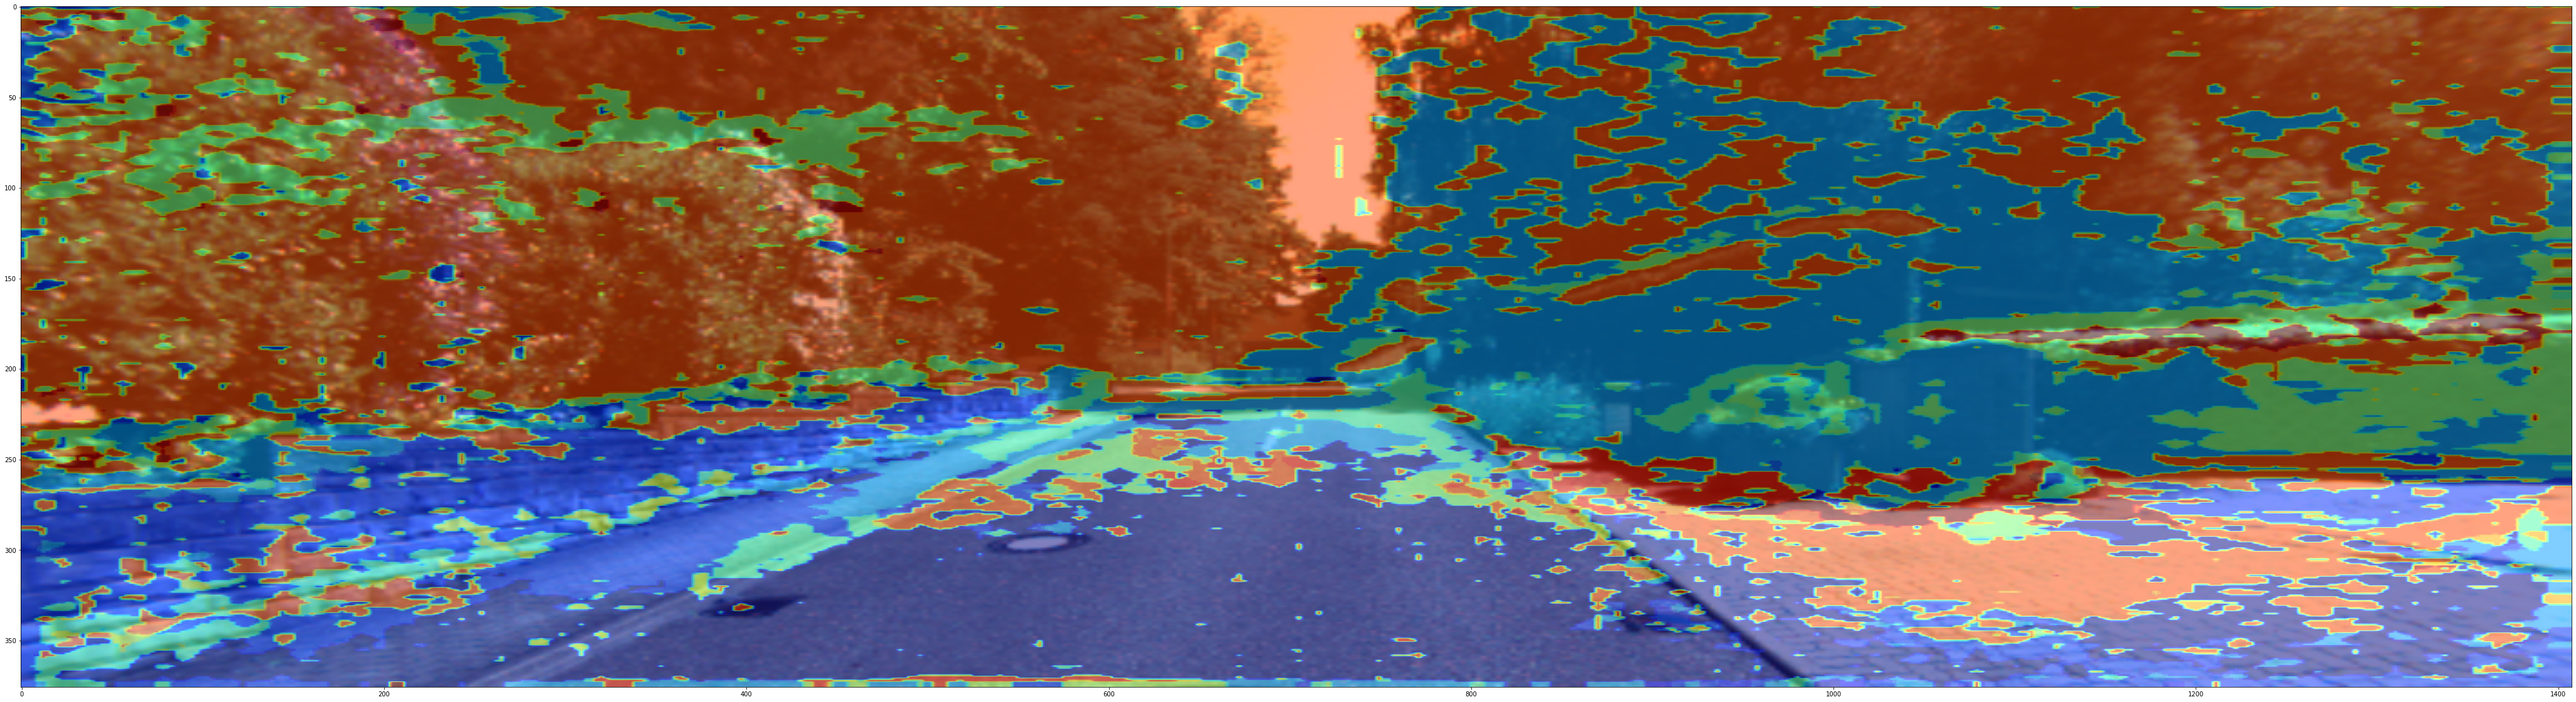

In [19]:
image = cv2.resize(image, (1408, 376))
preds_proc = cv2.resize(preds_proc, (1408, 376))

plt.figure(figsize=(100,20))
plt.imshow(image, cmap='gray', interpolation=None) # I would add interpolation='none'
plt.imshow(preds_proc, cmap='jet', alpha=0.5, interpolation=None) # interpolation='none'

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from PIL import Image

def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cityscapes_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 
               'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

[  0   1   2   4   5   7   8   9  10  13 255]


IndexError: index 255 is out of bounds for axis 0 with size 19

<Figure size 8640x1440 with 0 Axes>

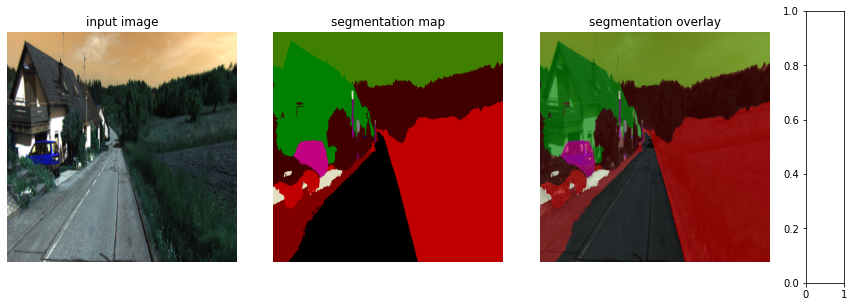

In [12]:
print(np.unique(lab))
plt.figure(figsize=(120,20))
vis_segmentation(image,lab)

In [4]:
test_generator = SegClass.create_generators(dataset ='../../kitti360_dataset.csv', subscene=2, blur=0, mode='test',
                                             n_classes=n_classes, horizontal_flip=True, vertical_flip=False, 
                                             brightness=0, rotation=False, zoom=0, batch_size=64,
                                             seed=7, do_ahisteq=False)

In [5]:
len(test_generator)

166

In [6]:
for n in range(len(test_generator)):
    x,y = test_generator.__getitem__(n)
    print(len(x))
#     plt.figure(figsize=(14,10))
#     plt.subplot(141)
#     plt.imshow(y[0].reshape(image_size).astype('uint8'))
#     plt.subplot(142)
#     plt.imshow(x[0])

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


In [22]:
import sys

def calculate_iou(model, valid_generator, nb_classes = 19, batch_size=32):
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    for n in range(len(valid_generator)):
        label = np.zeros((batch_size,np.prod(image_size)), dtype='uint8')    

        x,y = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        print("Starting prediction ", n, "...")
        preds = model.predict(x)
        print("Finished prediction ", n, "...")
        mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)    
        flat_pred = np.ravel(mask).astype('int')
        flat_label = np.ravel(label).astype('int')
        
        for p, l in zip(flat_pred, flat_label):
            if l == nb_classes:
                print("I dont understand...")
                continue
            if l < nb_classes and p < nb_classes:
                conf_m[l-1, p-1] += 1
            #else:
                #print('Invalid entry encountered, skipping! Label: ', l,
                 #       ' Prediction: ', p)
    
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    IOU = np.nan_to_num(IOU)
    meanIOU = np.mean(IOU)
    return conf_m

In [23]:
conf_1 = calculate_iou(deeplab_model, test_generator, nb_classes = 19, batch_size=32)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Text(0.5, 1.0, 'DeepLab\nMean IOU: nan')

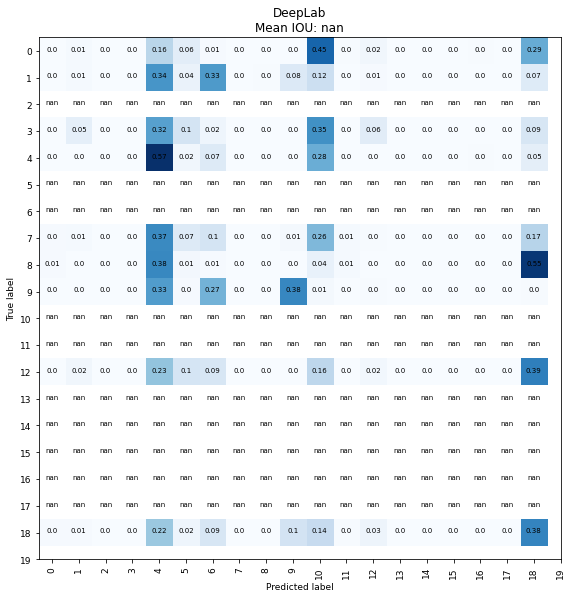

In [27]:
classes = [i for i in range(0,20)]
plt.figure(figsize=(12,8))
cm1 = plot_confusion_matrix(conf_1, classes, normalize=True)
plt.title('DeepLab\nMean IOU: '+ str(np.round(np.diag(cm1).mean(), 2)))

### Train with generator

In [3]:
train_generator = SegClass.create_generators(dataset ='../kitti360_dataset.csv', blur=0, mode='train',
                                             n_classes=n_classes, horizontal_flip=True, vertical_flip=False, 
                                             brightness=0, rotation=False, zoom=0, batch_size=bs,
                                             seed=7, do_ahisteq=False)

valid_generator = SegClass.create_generators(dataset ='../kitti360_dataset.csv', blur=0, mode='val',
                                             n_classes=n_classes, horizontal_flip=True, vertical_flip=False, 
                                             brightness=0, rotation=False, zoom=0, batch_size=bs,
                                             seed=7, do_ahisteq=False)

In [ ]:
monitor = 'Jaccard'
mode = 'max'

# fine-tune model (train only last conv layers)
if load_pretrained_weights:
    flag = 0
     for k, l in enumerate(model.layers):
        l.trainable = False
        if l.name == 'concat_projection':
            flag = 1
        if flag:
            l.trainable = True
        
def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir='./logs/'+SegClass.net, histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = SegClass.modelpath, verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)
        
SegClass.set_num_epochs(10)
history = SegClass.train_generator(model, train_generator, valid_generator, callbacks, mp = True)

### Compare Models

In [5]:
# Load original deeplab and subpixel-deeplab
model1 = SegClass.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model1.load_weights('weights/mobilenetv2_original.h5')
model2 = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model2.load_weights('weights/mobilenetv2_subpixel.h5')

In [6]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

In [11]:
import importlib  
keras_deeplab = importlib.import_module("keras-deeplab-v3-plus.model")

deeplab_model = keras_deeplab.Deeplabv3(backbone="xception", input_shape=(512, 512, 3), classes=19, weights='cityscapes')

ModuleNotFoundError: No module named 'keras-deeplab-v3-plus'

In [29]:
# Generates labels using most basic setup.  Supports various image sizes.  Returns image labels in same format
# as original image.  Normalization matches MobileNetV2

trained_image_width=512 
mean_subtraction_value=127.5
image = cv2.imread(images[400], 1)

# resize to max dimension of images from training dataset
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

# apply normalization for trained dataset images
resized_image = (resized_image / mean_subtraction_value) - 1.

# pad array to square image to match training images
pad_x = int(trained_image_width - resized_image.shape[0])
pad_y = int(trained_image_width - resized_image.shape[1])
resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

# make prediction
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
preds_lab = np.argmax(res.squeeze(), -1)
preds_lab_down = np.argmax(res.squeeze(), -1)

#remove padding and resize back to original image
if pad_x > 0:
    preds_lab = preds_lab[:-pad_x]
if pad_y > 0:
    preds_lab = preds_lab[:, :-pad_y]
preds_lab = np.array(Image.fromarray(preds_lab.astype('uint8')).resize((h, w))) 
preds_lab_down = np.array(Image.fromarray(preds_lab_down.astype('uint8')).resize((h, w))) 


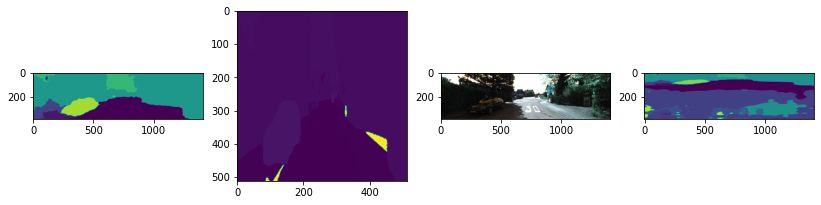

In [30]:
lab = cv2.imread(labels[400], 0)
lab = cv2.resize(lab, (512,512), interpolation = cv2.INTER_NEAREST)

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(preds_lab)
plt.subplot(142)
plt.imshow(lab)
plt.subplot(143)
plt.imshow(image)
plt.subplot(144)
plt.imshow(preds_lab_down)
#plt.subplot(244)
#plt.imshow(resized_image*255)

44


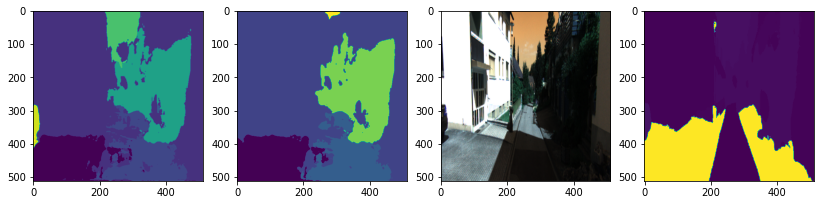

In [92]:
mean_subtraction_value=127.5

i = np.random.randint(0, len(test_generator))
print(i)
x,y = test_generator.__getitem__(i)
old_x = x[0]
x[0] = (x[0] / mean_subtraction_value) - 1.
preds1 = np.argmax(deeplab_model.predict(x), -1)[0].reshape(image_size)

t = (old_x + 1) * 127.5
t = t.astype('uint8')

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(preds1)
MAP = do_crf(x[0], preds1, zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP)
plt.subplot(143)
plt.imshow(t)
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))

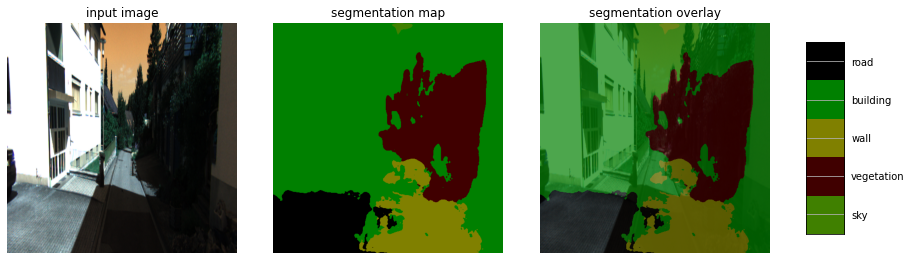

In [93]:
vis_segmentation(t,MAP)

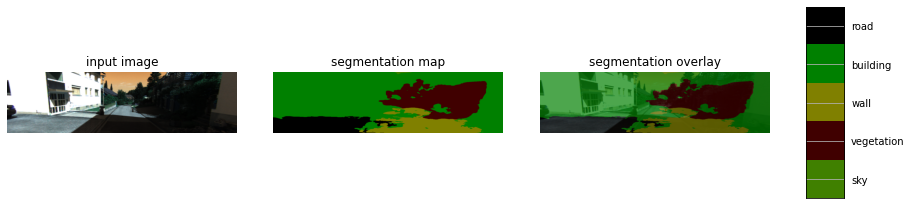

In [94]:
vis_segmentation(cv2.resize(t,(1408, 376)),cv2.resize(MAP,(1408, 376), interpolation = cv2.INTER_NEAREST))

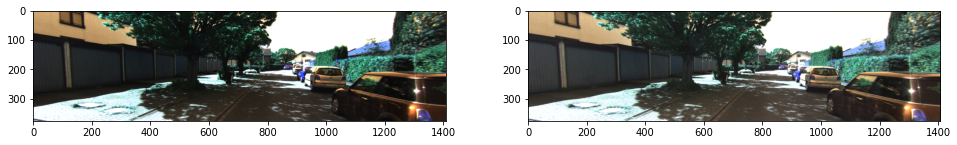

In [121]:
image = cv2.imread(images[5000], 1)
plt.figure(figsize=(34,30))
plt.subplot(141)
plt.imshow(image)

factor = 1.0 + random.gauss(mu=0.0, sigma=0.5)
if random.randint(0,1):
    factor = 1.0/factor
table = np.array([((i / 255.0) ** factor) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
image2 = cv2.LUT(image, table)
plt.subplot(142)
plt.imshow(image2)